In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
import cairo
num_imgs = 200

img_size = 16
min_object_size = 2
max_object_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
shapes = np.zeros((num_imgs, num_objects), dtype=int)
num_shapes = 3
shape_labels = ['rectangle', 'circle', 'triangle']
colors = np.zeros((num_imgs, num_objects), dtype=int)
num_colors = 3
color_labels = ['r', 'g', 'b']

for i_img in range(num_imgs):
    surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
    cr = cairo.Context(surface)

    # Fill background white.
    cr.set_source_rgb(1, 1, 1)
    cr.paint()
    
    # TODO: Try no overlap here.
    # Draw random shapes.
    for i_object in range(num_objects):
        shape = np.random.randint(num_shapes)
        shapes[i_img, i_object] = shape
        if shape == 0:  # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.rectangle(x, y, w, h)            
        elif shape == 1:  # circle   
            r = 0.5 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
            cr.arc(x, y, r, 0, 2*np.pi)
        elif shape == 2:  # triangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.move_to(x, y)
            cr.line_to(x+w, y)
            cr.line_to(x+w, y+h)
            cr.line_to(x, y)
            cr.close_path()
        
        # Put some variation to the colors by adding a small random offset to the rgb values.
        color = np.random.randint(num_colors)
        colors[i_img, i_object] = color
        max_offset = 0.3
        r_offset, g_offset, b_offset = max_offset * 2. * (np.random.rand(3) - 0.5)
        if color == 0:
            cr.set_source_rgb(1-max_offset+r_offset, 0+g_offset, 0+b_offset)
        elif color == 1:
            cr.set_source_rgb(0+r_offset, 1-max_offset+g_offset, 0+b_offset)
        elif color == 2:
            cr.set_source_rgb(0+r_offset, 0-max_offset+g_offset, 1+b_offset)
        cr.fill()
        
imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB

imgs.shape, bboxes.shape, shapes.shape, colors.shape

((200, 16, 16, 3), (200, 2, 4), (200, 2), (200, 2))

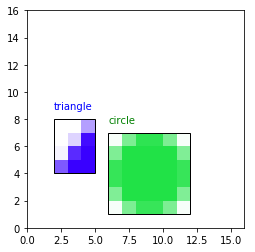

In [4]:
i = 2
plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape, color in zip(bboxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color=color_labels[color], clip_on=False)

In [5]:
imgs = np.transpose(imgs,(0,3,1,2))
print imgs.shape

(200, 3, 16, 16)


In [6]:
X = (imgs - 128.) / 255.
X.shape, np.mean(X), np.std(X)

((200, 3, 16, 16), 0.41336259191176472, 0.25072160663772702)

In [7]:
colors_onehot = np.zeros((num_imgs, num_objects, num_colors))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        colors_onehot[i_img, i_object, colors[i_img, i_object]] = 1

shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        shapes_onehot[i_img, i_object, shapes[i_img, i_object]] = 1
        
y = np.concatenate([bboxes / img_size, shapes_onehot, colors_onehot], axis=-1).reshape(num_imgs, -1)
y.shape, np.all(np.argmax(colors_onehot, axis=-1) == colors)

((200, 20), True)

In [8]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
print train_X.shape,train_y.shape

(160, 3, 16, 16) (160, 20)


In [9]:
from torchsummary import summary
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()

        #conv 1
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu1=nn.ReLU()

        #Maxpool 1
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        #conv 2
        self.cnn2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.relu2=nn.ReLU()

        #Maxpool 2
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        #conv 3
        self.cnn3=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2)
        self.relu3=nn.ReLU()

        #Maxpool 3
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        #FC 1
        self.fc1=nn.Linear(1152,256)
        self.relu4=nn.ReLU()
            
        #Drop out 
        self.dropout1 = nn.Dropout(0.2)
        
        #FC 2
        self.fc2=nn.Linear(256,20)
        

    def forward(self,x):
        '''
        ori=x[0][0].data.numpy()
        print ('original : ',ori.shape)
        plt.imshow(ori, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        #conv1
        out=self.cnn1(x)
        out=self.relu1(out)
        '''
        #print type(out)
        intm=out[0][0].data.numpy()
        print ('conv 1: ',intm.shape)
        #imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        #max poo1 1
        out=self.maxpool1(out)
        '''
        ap=out[0][0].data.numpy()
        print ('maxpool 1 : ',ap.shape)
        plt.imshow(ap, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        
        #conv2
        out=self.cnn2(out)
        out=self.relu2(out)
        '''
        intm=out[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        #max poo1 2
        out=self.maxpool2(out)
        '''
        ap=out[0][0].data.numpy()
        print ('maxpool 2 : ',ap.shape)
        plt.imshow(ap, cmap=plt.get_cmap('gray'))
        plt.show()
        '''
        
        #conv3
        out=self.cnn3(out)
        out=self.relu3(out)
        '''
        intm=out[0][0].data.numpy()
        print ('conv 3: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        #max poo1 3
        out=self.maxpool3(out)
        """ap=out[0][0].data.numpy()
        print ('maxpool 3 : ',ap.shape)
        plt.imshow(ap, cmap=plt.get_cmap('gray'))
        plt.show()
        """
        
        out=out.view(out.size(0),-1)        
        #fc1
        out=self.fc1(out)
        out=self.relu4(out) 
        
        
        #dropout
        out=self.dropout1(out)
        
        #fc2
        out=self.fc2(out)
        
        return out

In [13]:
model = CNNModel()

print summary(model, (3, 16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32L, 18L, 18L]             896
              ReLU-2        [-1, 32L, 18L, 18L]               0
         MaxPool2d-3          [-1, 32L, 9L, 9L]               0
            Conv2d-4        [-1, 64L, 11L, 11L]           18496
              ReLU-5        [-1, 64L, 11L, 11L]               0
         MaxPool2d-6          [-1, 64L, 5L, 5L]               0
            Conv2d-7         [-1, 128L, 7L, 7L]           73856
              ReLU-8         [-1, 128L, 7L, 7L]               0
         MaxPool2d-9         [-1, 128L, 3L, 3L]               0
           Linear-10                 [-1, 256L]          295168
             ReLU-11                 [-1, 256L]               0
          Dropout-12                 [-1, 256L]               0
           Linear-13                  [-1, 20L]            5140
Total params: 393556
Trainable params: 

In [14]:
model=CNNModel()
criterion=nn.MSELoss()
learning_rate=0.01
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))


In [22]:
num_epochs_flipping = 30
num_epochs_no_flipping = 0  # has no significant effect

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
acc_shapes_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
acc_colors_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))

In [26]:
loss_list=[]
for epoch in range(30):
    print 'Epoch', epoch
    inputs=Variable(torch.FloatTensor(train_X))
    labels=Variable(torch.FloatTensor(train_y))
    optimizer.zero_grad()
    outputs = model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    #if epoch%100==0:
    print ('epoch {}, loss {}'.format(epoch,loss.data[0])) 
    loss_list.append(loss.data[0])

    pred_y = model(Variable(torch.FloatTensor(train_X))).data.numpy()
    print type(pred_y)
    #Calculate iou/dist, but don't flip.
    for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):

        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)        

        for exp_bbox, pred_bbox in zip(exp_bboxes, pred_bboxes):
            ious_epoch[sample, epoch] += IOU(exp_bbox, pred_bbox)
            dists_epoch[sample, epoch] += dist(exp_bbox, pred_bbox)
            mses_epoch[sample, epoch] += np.mean(np.square(exp_bbox - pred_bbox))

            ious_epoch[sample, epoch] /= num_objects
            dists_epoch[sample, epoch] /= num_objects 
            mses_epoch[sample, epoch] /= num_objects 

    #print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
    print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
    print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
    print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))

Epoch 0
epoch 0, loss 0.145344659686
<type 'numpy.ndarray'>
Mean IOU: 0.105578238781
Mean dist: 0.263938697961
Mean mse: 0.137444585448
Epoch 1
epoch 1, loss 0.146122157574
<type 'numpy.ndarray'>
Mean IOU: 0.10079591481
Mean dist: 0.266691366749
Mean mse: 0.137385010272
Epoch 2
epoch 2, loss 0.145953088999
<type 'numpy.ndarray'>
Mean IOU: 0.101933037693
Mean dist: 0.265179068402
Mean mse: 0.137122988052
Epoch 3
epoch 3, loss 0.146019592881
<type 'numpy.ndarray'>
Mean IOU: 0.10346147019
Mean dist: 0.265595358713
Mean mse: 0.137203866154
Epoch 4
epoch 4, loss 0.146030649543
<type 'numpy.ndarray'>
Mean IOU: 0.101353288657
Mean dist: 0.26549935908
Mean mse: 0.137148820954
Epoch 5
epoch 5, loss 0.146016061306
<type 'numpy.ndarray'>
Mean IOU: 0.0995355295024
Mean dist: 0.265317339306
Mean mse: 0.136954361581
Epoch 6
epoch 6, loss 0.146126449108
<type 'numpy.ndarray'>
Mean IOU: 0.0957730592255
Mean dist: 0.264968023714
Mean mse: 0.136955085216
Epoch 7
epoch 7, loss 0.146635726094
<type 'numpy

In [27]:
pred_y1  = model(Variable(torch.FloatTensor(test_X))).data.numpy()
pred_y1 = pred_y1.reshape(len(pred_y1), num_objects, -1)
pred_bboxes = pred_y1[..., :4] * img_size
pred_shapes = np.argmax(pred_y1[..., 4:4+num_shapes], axis=-1).astype(int)  # take max from probabilities
# print pred_y[..., 4+num_shapes:4+num_shapes+num_colors].shape
# print np.argmax(pred_y[..., 5:8], axis=-1).shape
pred_colors = np.argmax(pred_y1[..., 4+num_shapes:4+num_shapes+num_colors], axis=-1).astype(int)
pred_bboxes.shape, pred_shapes.shape, pred_colors.shape

((40, 2, 4), (40, 2), (40, 2))

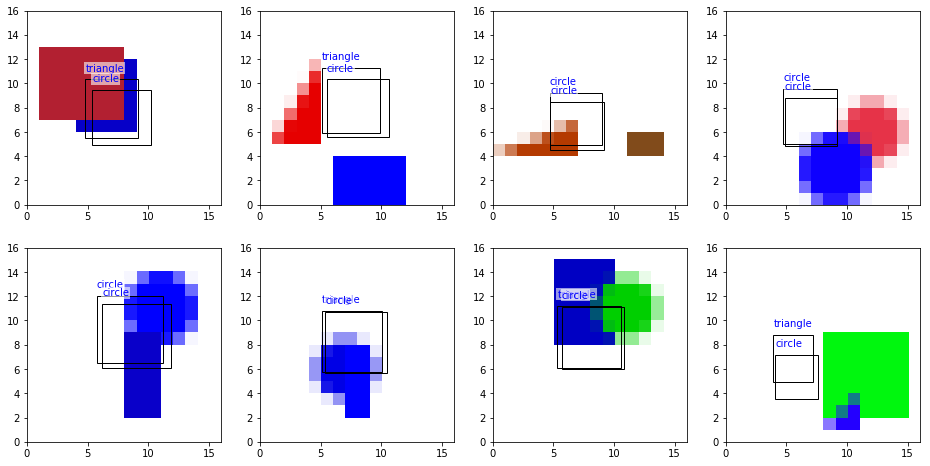

In [28]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    #print test_imgs[i].transpose(1,2,0).shape
    plt.imshow(test_imgs[i].transpose(1,2,0), interpolation='none', origin='lower', extent=[0, 16, 0, 16])
    for bbox, shape, color in zip(pred_bboxes[i], pred_shapes[i], pred_colors[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
        plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color=color_labels[color], clip_on=False, bbox={'fc': 'w', 'ec': 'none', 'pad': 1, 'alpha': 0.6})


In [29]:
torch.save(model.state_dict(), 'multibox_notflipped_chk.pt')

## The bounding boxes are centered to the objects in the data
## We need to handle the case of flipping 
reference https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491